In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import pandas as pd
import matplotlib 
import math

matplotlib.rcParams['figure.figsize'] = (25, 4)

In [2]:
params = [
    {'pi': 0.6, 'mu': 80, 'sigma': 50.5},
    {'pi': 0.4, 'mu': 10, 'sigma': 25.2}
]

In [3]:
total_toss = 900
num_cluster = len(params)

In [4]:
Z = [np.random.choice(num_cluster, 1, p=[params[i]['pi'] for i in range(num_cluster)])[0] for toss in range(total_toss)]

In [5]:
X = [(np.random.normal(params[z]["mu"], params[z]["sigma"], 1))[0] for z in Z]

In [6]:
random_Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for toss in range(total_toss)] 

In [7]:
d_list = []
for x, z, rz in zip(X, Z, random_Z):
    d_list.append([x, 1, z, rz])
dframe = pd.DataFrame(d_list, columns=["X", "Y","label", "random_label"])

In [8]:
# prior
def gaussian_pdf(x, mu, sigma):
    return np.exp(-1.0 * ((x - mu)**2)/(2 * sigma**2))/np.sqrt(2 * np.pi * sigma**2)

In [9]:
# use normal gamma to estimate mean and variance
def sample_mu_sigma(data, m=1, c =1, a =1, b =1):
    data = np.array(data)
    n = len(data)

    A = a + n/2
    C = c + n
    M = (c*m + np.sum(data))/(c + n)
    B = b + 0.5 * (c*m**2 - C * M**2 + np.sum(data**2))

    precision = np.random.gamma(shape=A, scale=1/B, size=1)[0]

    sigma = np.sqrt(1/precision)
    c_root = np.sqrt(1/C)

    mu = np.random.normal(loc=M, scale=sigma*c_root, size=1)[0]

    return mu, sigma

In [10]:
def generate_cluster(X, x_i, random_Z):
    clusters = {}
    for k in range(0, num_cluster):
        clusters[k] = []

    for (x, z_i) in zip(X, random_Z):
        if x == x_i:
            continue
        clusters[z_i].append(x)
    return clusters

In [11]:
mu = np.zeros(num_cluster)
sigma = np.zeros(num_cluster)

In [12]:
def calc_prob(x, X, random_Z, random_Z_count, N):
    clusters = generate_cluster(X, x, random_Z)
    
    for k in clusters:
        mu[k], sigma[k] = sample_mu_sigma(clusters[k])

    prob = []
    
    for k in range(num_cluster):
        prob_k = gaussian_pdf(x, mu[k], sigma[k])
        pr = ((random_Z_count[k] + A/num_cluster) / (A - 1 + N)) * prob_k
        
        prob.append(pr)
    return prob

In [13]:
import math
A =0.1 

total_likelihood = []
random_Z_count = Counter(random_Z)
N = len(X)

for _ in range(100):
    
    data_likelihood = []
    for i, (x, z) in enumerate(zip(X, random_Z)):
        prob = calc_prob(x, X, random_Z, random_Z_count, N)
        total_prob = np.sum(prob)
        
        norm_prob = [p/total_prob for p in prob]
        random_Z[i] = np.random.choice(num_cluster, 1, p=norm_prob)[0]

        data_likelihood.append(np.log(np.sum(prob)))
    
    total_likelihood.append(np.sum(data_likelihood))

In [14]:
d_list = []
for x, z, rz in zip(X, Z, random_Z):
    if z == rz:
        val = num_cluster
    else:
        val = z
    d_list.append([x, 1, z, rz, val])
dframe = pd.DataFrame(d_list, columns=["X", "Y","label", "model_label", "label==random_label"])

In [23]:
for i, row in dframe.iterrows():
    if row['label'] == 0:
        dframe.loc[i, 'label'] = 1
    elif row['label'] == 1:
        dframe.loc[i, 'label'] = 0

<AxesSubplot:xlabel='X', ylabel='Y'>

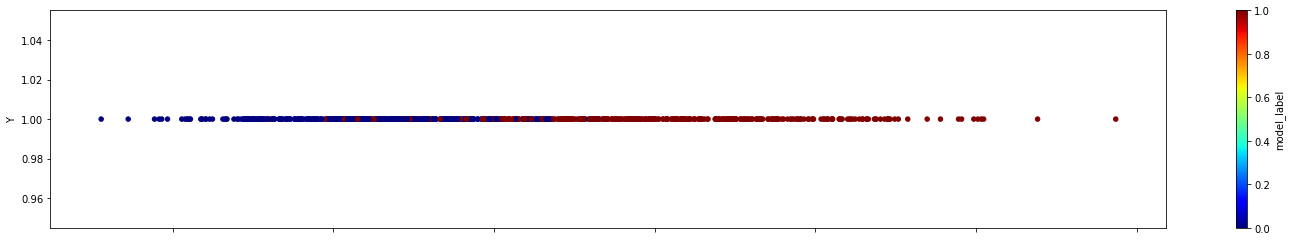

In [25]:
dframe.plot.scatter('X', 'Y', c='model_label', colormap='jet')

In [28]:
for i, row in dframe.iterrows():
    if row['label'] == row['model_label'] == 1:
        dframe.loc[i, "label==random_label"] = 1
    elif row['label'] == row['model_label'] == 0:
        dframe.loc[i, "label==random_label"] = 0
    else:
        dframe.loc[i, "label==random_label"] = 2

<AxesSubplot:xlabel='X', ylabel='Y'>

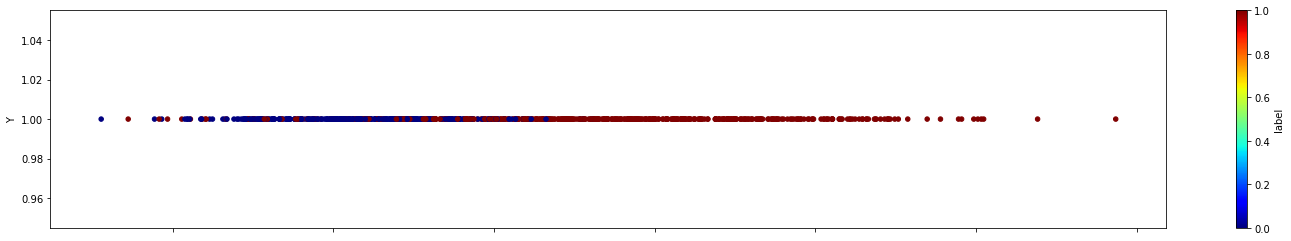

In [24]:
dframe.plot.scatter('X', 'Y', c='label', colormap='jet')

<AxesSubplot:xlabel='X', ylabel='Y'>

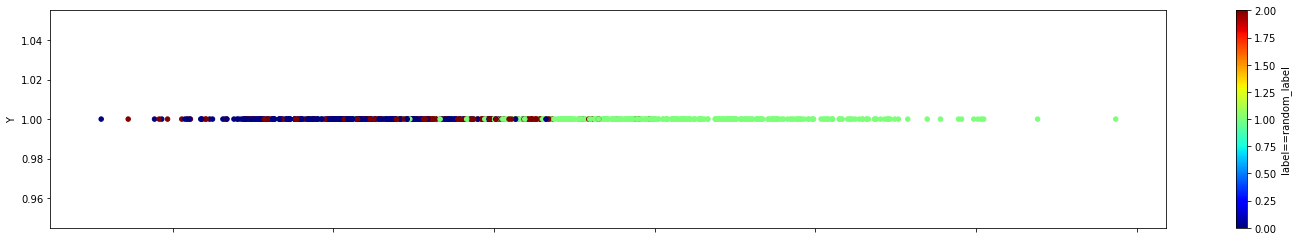

In [31]:
dframe.plot.scatter('X', 'Y', c='label==random_label', colormap='jet')

In [30]:
dframe[dframe["label==random_label"] == num_cluster].count()

X                      210
Y                      210
label                  210
model_label            210
label==random_label    210
dtype: int64

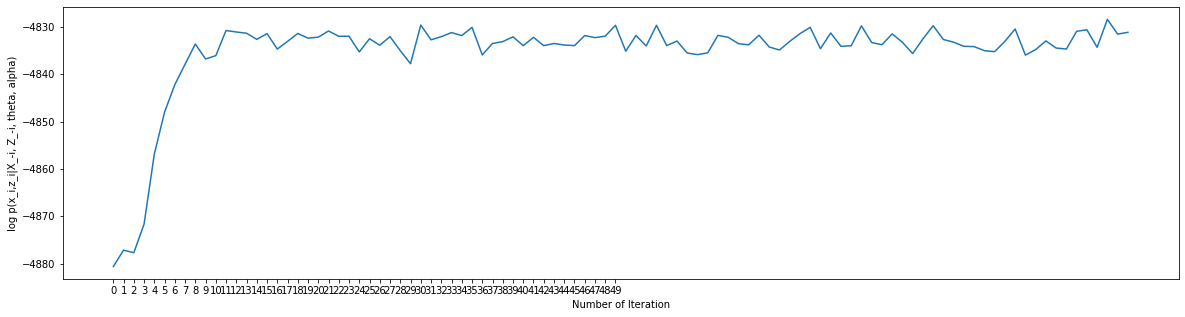

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(total_likelihood)
plt.xlabel("Number of Iteration")
plt.ylabel("log p(x_i,z_i|X_-i, Z_-i, theta, alpha)")
plt.xticks([i for i in range(50)])

plt.show()

In [32]:
model_params = []
for i, df in dframe.groupby('model_label'):
    d = {}
    d['pi'] = len(df)/total_toss
    d['mu'] = np.round(np.mean(df[["X"]].to_numpy().T),2)
    d['sigma'] = np.std(df["X"])
    model_params.append(d)

In [33]:
model_params

[{'pi': 0.5033333333333333, 'mu': 12.87, 'sigma': 28.19962158482112},
 {'pi': 0.49666666666666665, 'mu': 91.8, 'sigma': 45.848379676324605}]

In [34]:
params

[{'pi': 0.6, 'mu': 80, 'sigma': 50.5}, {'pi': 0.4, 'mu': 10, 'sigma': 25.2}]